In [1]:
!pip install datasets
!pip install tqdm
!pip install sentencepiece
!pip install word2vec
!pip install gensim
!pip install matplotlib

In [2]:
from datasets import load_dataset
import pandas as pd
import numpy as np
import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import torch.nn.functional as F
import sentencepiece as spm
import gensim
from gensim.models import Word2Vec
import random
from tqdm import tqdm
import torch
import json
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import torch.nn.functional as F
from mlflow import MlflowClient
from pprint import pprint
from sklearn.ensemble import RandomForestRegressor

/Users/beesamprajveenkumar/miniconda3/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
dataset = load_dataset('ms_marco', 'v1.1')

In [4]:
train_data = dataset['train']
validation_data = dataset['validation']
test_data = dataset['test']

In [5]:
print('train size: ', train_data.shape)
print('validation size: ', validation_data.shape)
print('test size: ', test_data.shape)

train size:  (82326, 6)
validation size:  (10047, 6)
test size:  (9650, 6)


In [6]:
# covert to pandas

train_df = train_data.to_pandas()
validation_df = validation_data.to_pandas()
test_df = test_data.to_pandas()

In [7]:
train_df.head()

,answers,passages,query,query_id,query_type,wellFormedAnswers
0,[Results-Based Accountability is a disciplined...,"{'is_selected': [0, 0, 0, 0, 0, 1, 0, 0, 0, 0]...",what is rba,19699,description,[]
1,[Yes],"{'is_selected': [0, 1, 0, 0, 0, 0, 0], 'passag...",was ronald reagan a democrat,19700,description,[]
2,[20-25 minutes],"{'is_selected': [0, 0, 0, 0, 1, 0, 0, 0, 0, 0]...",how long do you need for sydney and surroundin...,19701,numeric,[]
3,[$11 to $22 per square foot],"{'is_selected': [0, 0, 0, 0, 0, 0, 0, 0, 1], '...",price to install tile in shower,19702,numeric,[]
4,[Due to symptoms in the body],"{'is_selected': [0, 0, 1, 0, 0, 0, 0, 0], 'pas...",why conversion observed in body,19703,description,[]


In [8]:
test_df.head()

,answers,passages,query,query_id,query_type,wellFormedAnswers
0,[Yes],"{'is_selected': [0, 0, 1, 0, 0, 0, 0], 'passag...",does human hair stop squirrels,0,description,[]
1,[Fossil fuels are basically the remains of ani...,"{'is_selected': [0, 1, 0, 0, 0, 0, 0, 0, 0], '...",what are the benefits of fossil fuels,1,description,[]
2,[The apothem of a regular polygon is a line se...,"{'is_selected': [0, 0, 0, 0, 0, 1, 0, 0, 0], '...",what is a apothem,2,description,[]
3,[$45 to $210. 2],"{'is_selected': [0, 0, 0, 0, 0, 1, 0, 0, 0], '...",average cost for custom canopy,3,numeric,[]
4,[It is the collection of physical elements tha...,"{'is_selected': [0, 1, 0, 0, 0, 0, 0, 0, 0, 0]...",what is a hardware in a computer,4,description,[]


In [9]:
train_df  = train_df[:100]
validation_df = validation_df[:60]
test_df = test_df[:10]

In [10]:
train_df['passages'][0], train_df['query'][0]

({'is_selected': array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0], dtype=int32),
  'passage_text': array(["Since 2007, the RBA's outstanding reputation has been affected by the 'Securency' or NPA scandal. These RBA subsidiaries were involved in bribing overseas officials so that Australia might win lucrative note-printing contracts. The assets of the bank include the gold and foreign exchange reserves of Australia, which is estimated to have a net worth of A$101 billion. Nearly 94% of the RBA's employees work at its headquarters in Sydney, New South Wales and at the Business Resumption Site.",
         "The Reserve Bank of Australia (RBA) came into being on 14 January 1960 as Australia 's central bank and banknote issuing authority, when the Reserve Bank Act 1959 removed the central banking functions from the Commonwealth Bank. The assets of the bank include the gold and foreign exchange reserves of Australia, which is estimated to have a net worth of A$101 billion. Nearly 94% of the RBA's employe

# Queries and documents

In [11]:
# train set
train_queries = train_df['query'].values
train_docs = train_df['passages'].values
train_docs_selected = [query_doc['is_selected'] for query_doc in train_docs]
train_docs_text = [query_doc['passage_text'] for query_doc in train_docs]

# validation set
validation_queries = validation_df['query'].values
validation_docs = validation_df['passages'].values
validation_docs_selected = [query_doc['is_selected'] for query_doc in validation_docs]
validation_docs_text = [query_doc['passage_text'] for query_doc in validation_docs]

# test set
test_queries = test_df['query'].values
test_docs = test_df['passages'].values
test_docs_selected = [query_doc['is_selected'] for query_doc in test_docs]
test_docs_text = [query_doc['passage_text'] for query_doc in test_docs]


In [12]:
train_queries[0]

'what is rba'

In [13]:
train_docs_text[0]

array(["Since 2007, the RBA's outstanding reputation has been affected by the 'Securency' or NPA scandal. These RBA subsidiaries were involved in bribing overseas officials so that Australia might win lucrative note-printing contracts. The assets of the bank include the gold and foreign exchange reserves of Australia, which is estimated to have a net worth of A$101 billion. Nearly 94% of the RBA's employees work at its headquarters in Sydney, New South Wales and at the Business Resumption Site.",
       "The Reserve Bank of Australia (RBA) came into being on 14 January 1960 as Australia 's central bank and banknote issuing authority, when the Reserve Bank Act 1959 removed the central banking functions from the Commonwealth Bank. The assets of the bank include the gold and foreign exchange reserves of Australia, which is estimated to have a net worth of A$101 billion. Nearly 94% of the RBA's employees work at its headquarters in Sydney, New South Wales and at the Business Resumption Sit

In [14]:
# get unique docs
docs = train_docs_text + validation_docs_text + test_docs_text
docs = list(
    {
        doc_text for passages in docs for doc_text in passages
    }
)
print('Unique docs: ', len(docs))
# get document - id dict
doc_id_dict = {
    docs[i]: i for i in range(0, len(docs))
}
id_doc_dict = {v: k for k, v in doc_id_dict.items()}

# Save the dictionary to a JSON file
with open("id_doc_dict.json", "w") as f:
    json.dump(id_doc_dict, f)


Unique docs:  1389


In [15]:
len(doc_id_dict)

1389

In [16]:
id_doc_dict[811]

'Heat is transferred in several different ways, either conduction, convection, and radiation. Regardless of the method of transfer, only heat can be transferred. Cold is simply the absence of heat and cannot be transferred by any method. Conduction is the transfer of heat from one molecule to another through a substance. Not all substances conduct heat at the same speed. Metals are considered good conductors since they can speedily transfer heat. Stone is also a moderately good conductor, but wood, paper, air, and cloth are poor heat conductors'

In [17]:
# update selected ids
# train
train_doc_ids_selected = [
    [doc_id_dict[doc_text] for doc_text in passages]
    for passages in train_docs_text
]

# validation
validation_doc_ids_selected = [
    [doc_id_dict[doc_text] for doc_text in passages]
    for passages in validation_docs_text
]

# test
test_doc_ids_selected = [
    [doc_id_dict[doc_text] for doc_text in passages]
    for passages in test_docs_text
]

# Triplets

In [18]:
# all queries to relevant docs dict
all_queries = list(train_queries) + list(validation_queries) + list(test_queries)
# train
query_rel_doc_ids_train_dict = {
    train_queries[i]: train_doc_ids_selected[i]
    for i in range(0, len(train_queries))
}
# validation
query_rel_doc_ids_val_dict = {
    validation_queries[i]: validation_doc_ids_selected[i]
    for i in range(0, len(validation_queries))
}
# test
query_rel_doc_ids_test_dict = {
    test_queries[i]: test_doc_ids_selected[i]
    for i in range(0, len(test_queries))
}
# merge all together in single dict
query_rel_doc_ids_dict = query_rel_doc_ids_train_dict | query_rel_doc_ids_val_dict
query_rel_doc_ids_dict = query_rel_doc_ids_dict | query_rel_doc_ids_test_dict

assert len(
    query_rel_doc_ids_dict
) == train_df.shape[0] + validation_df.shape[0] + test_df.shape[0]

In [19]:
def get_query_triples(queries, doc_ids, query_rel_doc_ids_dict):
    triplets = []
    for query in queries:
        relevant_docs_ids = query_rel_doc_ids_dict.get(query, [])  # Use .get() to handle cases where query is not in the dictionary
        irrelevant_docs = list(doc_ids - set(relevant_docs_ids))
        n_neg_samples = len(relevant_docs_ids)
        negative_docs_ids = random.sample(irrelevant_docs, n_neg_samples)
        triplets.extend([(query, relevant_docs_ids[j], negative_docs_ids[j]) for j in range(n_neg_samples)])
    return triplets

In [20]:
triples = []
doc_ids = set(doc_id_dict.values())
triples = get_query_triples(all_queries, doc_ids ,query_rel_doc_ids_dict)

In [21]:
triples[0], triples[1], triples[2], triples[3], triples[4], triples[5], triples[6], triples[7], triples[8], triples[9]

(('what is rba', 679, 910),
 ('what is rba', 1189, 1228),
 ('what is rba', 1169, 530),
 ('what is rba', 1387, 895),
 ('what is rba', 986, 12),
 ('what is rba', 277, 899),
 ('what is rba', 573, 462),
 ('what is rba', 484, 1104),
 ('what is rba', 297, 360),
 ('what is rba', 1302, 202))

In [22]:
id_doc_dict[triples[1][1]]

"The Reserve Bank of Australia (RBA) came into being on 14 January 1960 as Australia 's central bank and banknote issuing authority, when the Reserve Bank Act 1959 removed the central banking functions from the Commonwealth Bank. The assets of the bank include the gold and foreign exchange reserves of Australia, which is estimated to have a net worth of A$101 billion. Nearly 94% of the RBA's employees work at its headquarters in Sydney, New South Wales and at the Business Resumption Site."

# Tokenization

In [23]:
# Initialize the corpus with all_queries
corpus = all_queries.copy()
# Concatenate document texts to the corpus
for doc_text in docs:
    corpus.append(doc_text)  # Access the 'passage_text' key to get the passage text

assert len(corpus) == len(all_queries) + len(docs)

corpus_filename = 'corpus.txt'
# save corpus as .txt
with open(corpus_filename, 'w') as f:
    for sentence in corpus:
        f.write(sentence + '\n')

In [24]:
spm.SentencePieceTrainer.train('--input=corpus.txt --model_prefix=m --vocab_size=4771 --normalization_rule_name=nfkc_cf')
sp = spm.SentencePieceProcessor()
sp.load('m.model')

sentencepiece_trainer.cc(178) LOG(INFO) Running command: --input=corpus.txt --model_prefix=m --vocab_size=4771 --normalization_rule_name=nfkc_cf
sentencepiece_trainer.cc(78) LOG(INFO) Starts training with : 
trainer_spec {
  input: corpus.txt
  input_format: 
  model_prefix: m
  model_type: UNIGRAM
  vocab_size: 4771
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  pretokenization_delimiter: 
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  seed_sentencepieces_file: 
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id: 0
  bos_id: 1
  eos_id: 2
  pad_id:

True

In [25]:
# Tokenized sentences as pieces
# In the corpus you have all the data of the queries and also the passages, so the tokenization is done on everything
tokenized_sentences = sp.encode_as_pieces(corpus)
tokenized_sentences = {
    corpus[i]: tokenized_sentences[i]
    for i in range(0, len(corpus))
}
# Tokenized sentences as ids
tokenized_sentences_with_ids = sp.encode_as_ids(corpus)
tokenized_sentences_with_ids = {
    corpus[i]: tokenized_sentences_with_ids[i]
    for i in range(0, len(corpus))
}

In [26]:
vocabulary = list(
    {
        token for token_sent in tokenized_sentences.values()
        for token in token_sent
    }
)
print('vocabulary size: ', len(vocabulary))

vocabulary size:  4845


# Word2vec

In [27]:
# Train Word2Vec model
model = Word2Vec(
    tokenized_sentences.values(),
    vector_size=100,
    window=5,
    min_count=1,
    workers=4
    #sg=1, # 1 for Skip-Gram, default 0 for BGOW
    # SG is more computationally costly for bug data BGOW might be as good!
)
# Save the trained model
model.save("word2vec.model")
embeddings = model.wv.vectors
embeds = model.wv
print(f"The length of the embeddings with wv.vectors is {len(embeddings)}")
print(f"The length of the embedding with wv is {len(embeds)}")

# Create a dictionary mapping each token to its embedding
token_embeddings = {token: embeddings[i] for i, token in enumerate(vocabulary)}
token_embeddings_with_ids = {
    i: embeddings[i] for i, token in enumerate(vocabulary)
}

The length of the embeddings with wv.vectors is 4845
The length of the embedding with wv is 4845


In [28]:
# Get the vocabulary (list of tokens)
vocabulary = model.wv.index_to_key

# RNN / GRU / LSTM

In [29]:

# 2-TOWER NN
class TwoTowerNN(nn.Module):
    "TwoTower architecture tries to capture the fact that"
    "queries and documents have different semantic, syntactic structures"
    def __init__(
        self, sp_model_path, word2vec_model_path,
        embedding_dim,#query_input_dim, doc_input_dim,
        query_hidden_size, doc_hidden_size, query_num_layers, doc_num_layers,
        output_size, vocab_size, fine_tune,
    ):
        # setup sentencepiece tokenizer model
        self.sp_model = spm.SentencePieceProcessor()
        self.sp_model.load(sp_model_path)
        # setup word2vec model
        self.word2vec_model = Word2Vec.load(word2vec_model_path)
        # fine_tune parameter
        self.fine_tune = fine_tune
        super(TwoTowerNN, self).__init__()

        # Fine-tune word embeddings
        if self.fine_tune:
          # Embedding layers
          self.query_embedding = nn.Embedding(vocab_size, embedding_dim)
          self.doc_embedding = nn.Embedding(vocab_size, embedding_dim)

        # Towers:
        # Query tower
        self.query_tower = nn.GRU(
            embedding_dim, #if not fine_tune else vocab_size, #embedding_dim, #query_input_size,
            query_hidden_size,
            query_num_layers,
            batch_first=True
        )
        # Document tower
        self.doc_tower = nn.GRU(
            embedding_dim, #if not fine_tune else vocab_size, #embedding_dim, #doc_input_size,
            doc_hidden_size,
            doc_num_layers,
            batch_first=True,
        )

    # forward function
    def forward(self, query_input, doc_input):
        if self.fine_tune:
            # Embedding lookup
            if query_input is not None:
              query_embedded = self.query_embedding(query_input)
            if doc_input is not None:
              doc_embedded = self.doc_embedding(doc_input)
            # RNN forward pass
            if query_embedded is not None:
              _, query_hidden = self.query_tower(query_embedded)
            if doc_embedded is not None:
              _, doc_hidden = self.doc_tower(doc_embedded)
        else:
            # RNN forward pass
            if query_input is not None:
              _, query_hidden = self.query_tower(query_input)
            if doc_input is not None:
              _, doc_hidden = self.doc_tower(doc_input)

        if query_input is None:
          query_embedding = None
        else:
          query_embedding = query_hidden[-1]

        if doc_input is None:
          doc_embedding = None
        else:
          doc_embedding = doc_hidden[-1]

        # Return query and document embeddings
        return query_embedding, doc_embedding


    # Define preprocess_query function
    def prepare(self, text):
        # Tokenize the text using SentencePiece model
        processed_text = self.sp_model.encode_as_ids(text)
        # Vectorize the text using Word2Vec model
        if not self.fine_tune:
          processed_text = [
              self.word2vec_model.wv.get_vector(tok)for tok in processed_text
          ]
        return processed_text


    # get document embeddings
    def get_document_embeddings(self, documents):
        # Preprocess candidate documents
        processed_documents = [
            self.prepare(doc) for doc in documents
        ]

        # Encode candidate documents
        document_embeddings = []
        for doc_input in processed_documents:
            doc_input = torch.tensor(doc_input)  # Convert to tensor if required
            _, doc_embedding = self.forward(None, doc_input)
            document_embeddings.append(doc_embedding)

        return document_embeddings


    # predict function
    def predict(
        self, new_query, candidate_docs_ids, doc_emb_dict, id_doc_dict, k,
    ):
        # Preprocess the new query
        query_input = self.prepare(new_query)

        # Encode the query
        query_input = torch.tensor(query_input)  # Convert to tensor if required
        query_embedding, _ = self.forward(query_input, None)

        # get document encodings/embeddings
        candidate_documents = [
            id_doc_dict[doc_id] for doc_id in candidate_docs_ids
        ]
        docs_in_dict = list(
            set(candidate_documents).intersection(set(doc_emb_dict.keys()))
        )
        docs_not_in_dict = list(
            set(candidate_documents) - set(doc_emb_dict.keys())
        )

        document_embeddings = {}
        if len(docs_in_dict) > 0:
          document_embeddings.update(
              {doc: doc_emb_dict[doc] for doc in docs_in_dict}
          )
        if len(docs_not_in_dict) > 0:
          can_doc_embeddings = self.get_document_embeddings(
              docs_not_in_dict
          )
          document_embeddings.update(
              {
                  doc: emb for doc, emb in zip(
                      docs_not_in_dict, can_doc_embeddings,
                  )
              }
          )

        # Calculate cosine similarity scores
        similarity_scores = [
          F.cosine_similarity(
              query_embedding.unsqueeze(0), doc_embedding.unsqueeze(0), dim=1
          ).item() for doc_embedding in document_embeddings.values()
        ]

        # Rank documents by similarity
        ranked_documents = sorted(zip(document_embeddings.keys(), similarity_scores),key=lambda x: x[1], reverse=True)

        # Retrieve top-K documents
        top_k_documents = ranked_documents[:k]

        return top_k_documents
    
   

In [30]:
class TwoTowerDataset(Dataset):
    def __init__(
        self, triples, id_doc_dict,
        tokenized_id_sentences, token_id_embeddings, fine_tune,
    ):
        self.triples = triples
        self.doc_dict = id_doc_dict
        self.tokenized_id_sentences = tokenized_id_sentences
        self.token_id_embeddings = token_id_embeddings
        self.fine_tune = fine_tune

    def __len__(self):
        return len(self.triples)

    def __getitem__(self, idx):
        query, positive_indx, negative_indx = self.triples[idx]
        positive_doc = self.doc_dict[positive_indx]
        negative_doc = self.doc_dict[negative_indx]
        # if not fine_tune take the collection of token embeddings
        if not self.fine_tune:
          # query
          tok_query = self.tokenized_id_sentences[query]
          query = np.array(
              [self.token_id_embeddings[tok] for tok in tok_query]
          )
          # postive doc
          tok_pos_doc = self.tokenized_id_sentences[positive_doc]
          positive_doc = np.array(
              [self.token_id_embeddings[tok] for tok in tok_pos_doc]
          )
          # negative doc
          tok_neg_doc = self.tokenized_id_sentences[negative_doc]
          negative_doc = np.array(
              [self.token_id_embeddings[tok] for tok in tok_neg_doc]
          )

        # if fine_tune take the tokenized sentences
        else:
          query = self.tokenized_id_sentences[query]
          positive_doc = self.tokenized_id_sentences[positive_doc]
          negative_doc = self.tokenized_id_sentences[negative_doc]

        return (
            query,
            positive_doc,
            negative_doc,
        )

In [31]:
def collate_fn(batch, fine_tune):
    # MAKE ALL SAME SHAPE!!
    # if training token embeddings within we need int else float
    if fine_tune:
      torch_type=torch.int64
    else:
      torch_type=torch.float32
    # Sort batch by sequence length (optional but can improve efficiency)
    batch.sort(key=lambda x: len(x[0]), reverse=True)

    # Extract context sequences and target indices
    queries, pos_docs, neg_docs = zip(*batch)

    # Pad context sequences to the length of the longest sequence in the batch
    padded_queries = pad_sequence(
        [torch.tensor(query, dtype=torch_type) for query in queries],
        batch_first=True, padding_value=0,
      )
    padded_pos_docs = pad_sequence(
        [torch.tensor(pos_doc, dtype=torch_type) for pos_doc in pos_docs],
        batch_first=True, padding_value=0,
    )
    padded_neg_docs = pad_sequence(
        [torch.tensor(neg_doc, dtype=torch_type) for neg_doc in neg_docs],
        batch_first=True, padding_value=0,
    )

    return padded_queries, padded_pos_docs, padded_neg_docs

In [32]:
# train triples
train_triples = [triple for triple in triples if triple[0] in train_queries]
# validation triples
validation_triples = [
    triple for triple in triples if triple[0] in validation_queries
]
# test triples
test_triples = [triple for triple in triples if triple[0] in test_queries]

train_triples[0][1]

679

In [33]:
# Example values
# Training loop
num_epochs = 10
vocab_size = 10000
embedding_dim = 100
query_hidden_size = 64
doc_hidden_size = 64
query_num_layers = 2
doc_num_layers = 2
output_size = 1
fine_tune=False

In [34]:
# Create train dataset instance
train_dataset = TwoTowerDataset(
    train_triples, id_doc_dict,
    tokenized_sentences_with_ids, token_embeddings_with_ids, fine_tune,
    )
# Create validation dataset instance
val_dataset = TwoTowerDataset(
    validation_triples, id_doc_dict,
    tokenized_sentences_with_ids, token_embeddings_with_ids, fine_tune,
)

# Define batch size
batch_size = 32

# Create DataLoaders for training and validation
train_dataloader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True,
    collate_fn=lambda b: collate_fn(b, fine_tune),
)
val_dataloader = DataLoader(
    val_dataset, batch_size=batch_size,
    collate_fn=lambda b: collate_fn(b, fine_tune),
)

Epoch 1/10, Train Loss: 0.0267, Val Loss: 0.6930


Epoch 2/10, Train Loss: 0.0800, Val Loss: 0.6934


Epoch 3/10, Train Loss: 0.1600, Val Loss: 0.6934


Epoch 4/10, Train Loss: 0.2666, Val Loss: 0.6933


Epoch 5/10, Train Loss: 0.3999, Val Loss: 0.6929


Epoch 6/10, Train Loss: 0.5599, Val Loss: 0.6927


Epoch 7/10, Train Loss: 0.7465, Val Loss: 0.6928


Epoch 8/10, Train Loss: 0.9597, Val Loss: 0.6932


Epoch 9/10, Train Loss: 1.1995, Val Loss: 0.6932


Epoch 10/10, Train Loss: 1.4661, Val Loss: 0.6933


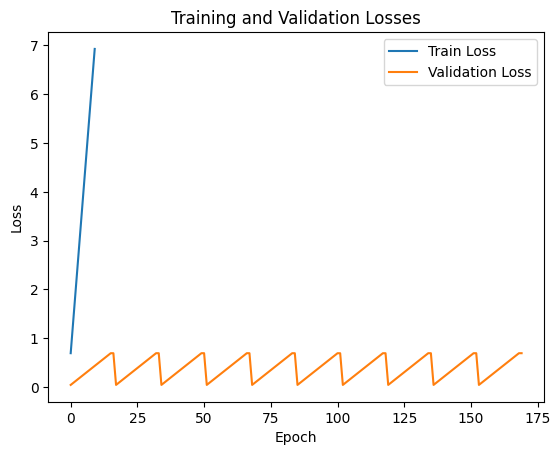

Training finished.
Final Train Loss: 3.8117, Final Val Loss: 0.6933


In [35]:
# Instantiate the model
two_tower_model = TwoTowerNN(
    sp_model_path='m.model', word2vec_model_path='word2vec.model',
    embedding_dim=embedding_dim,
    query_hidden_size=query_hidden_size, doc_hidden_size=doc_hidden_size,
    query_num_layers=query_num_layers, doc_num_layers=doc_num_layers,
    output_size=output_size, vocab_size=vocab_size, fine_tune=fine_tune,
)

# Define optimizer
optimizer = optim.Adam(two_tower_model.parameters(), lr=0.01)
train_loss = 0.0
# Training loop
train_losses = []
val_losses = []
for epoch in range(num_epochs):
    # Iterate over batches of data
    for batch in tqdm(
        train_dataloader, desc=f'Epoch {epoch+1}/{num_epochs}', leave=False,
    ):
        # Assuming dataloader yields query_input, doc_input, labels
        query_input, pos_doc_input, neg_doc_input = batch

        # Forward pass positive sampling
        query_embedding, pos_doc_embedding = two_tower_model(
            query_input, pos_doc_input,
        )

        # Negative sampling
        _, neg_doc_embedding = two_tower_model(query_input, neg_doc_input)

        # Compute cosine similarity
        similarity = F.cosine_similarity(
            query_embedding, pos_doc_embedding, dim=1,
        )

        # Compute negative similarity
        negative_similarity = F.cosine_similarity(
            query_embedding, neg_doc_embedding, dim=1,
        )

        # Create binary labels
        # 1 for all positive / 0 for all negative
        binary_labels = torch.ones_like(similarity)  # Positive pairs
        binary_labels = torch.where(
            binary_labels == 0, torch.zeros_like(binary_labels), binary_labels,
        )  # Negative pairs

        # Calculate loss
        loss = F.binary_cross_entropy_with_logits(
            similarity - negative_similarity, binary_labels,
        )


        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Track training loss
        train_loss += loss.item()

        # Track training loss
    avg_train_loss = train_loss / len(train_dataloader)
    train_losses.append(avg_train_loss)

    # Validation loop
    val_loss = 0.0
    with torch.no_grad():
        for batch in val_dataloader:
            query_input, pos_doc_input, neg_doc_input = batch

            # Forward pass positive sampling
            query_embedding, pos_doc_embedding = two_tower_model(query_input, pos_doc_input)

            # Compute cosine similarity
            similarity = F.cosine_similarity(query_embedding, pos_doc_embedding, dim=1)

            # Negative sampling
            _, neg_doc_embedding = two_tower_model(query_input, neg_doc_input)

            # Compute negative similarity
            negative_similarity = F.cosine_similarity(query_embedding, neg_doc_embedding, dim=1)

            # Create binary labels
            binary_labels = torch.ones_like(similarity)  # Positive pairs
            binary_labels = torch.where(
                binary_labels == 0, torch.zeros_like(binary_labels), binary_labels
            )  # Negative pairs

            # Calculate loss
            loss = F.binary_cross_entropy_with_logits(
                similarity - negative_similarity, binary_labels,
            )

            val_loss += loss.item()
            avg_val_loss = val_loss / len(val_dataloader)
            val_losses.append(avg_val_loss)
            
            
    # Save the model after training
    torch.save(two_tower_model.state_dict(), 'two_tower_model.pth')

    # Compute average validation loss
    avg_val_loss = val_loss / len(val_dataloader)
    val_losses.append(avg_val_loss)
    # Print losses for this epoch
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {sum(train_losses[-len(train_dataloader):])/len(train_dataloader):.4f}, Val Loss: {avg_val_loss:.4f}")

# Plotting loss curves
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.show()

# After training loop, print final losses
print("Training finished.")
print(f"Final Train Loss: {sum(train_losses)/len(train_losses):.4f}, Final Val Loss: {val_losses[-1]:.4f}")

In [36]:

#two_tower_model.load_state_dict(torch.load('two_tower_model.pth'))
# Initialize the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
two_tower_model.to(device)
#two_tower_model.eval()
eval_model = TwoTowerNN( 
    sp_model_path='m.model', word2vec_model_path='word2vec.model',
    embedding_dim=embedding_dim,
    query_hidden_size=query_hidden_size, doc_hidden_size=doc_hidden_size,
    query_num_layers=query_num_layers, doc_num_layers=doc_num_layers,
    output_size=output_size, vocab_size=vocab_size, fine_tune=fine_tune,
)
eval_model.load_state_dict(torch.load('two_tower_model.pth'))
eval_model.to(device)
eval_model.eval()

for param in eval_model.parameters():
    param.requires_grad = False

In [37]:
def pred(query, model, word2vec_model):
    # Tokenize the text using SentencePiece model
    query_token = sp.encode_as_ids(query)
    # Vectorize the text using Word2Vec model
    query_embeddings = [word2vec_model.wv.get_vector(tok) for tok in query_token]
    # Convert the embeddings to tensors and stack them
    query_embeddings = torch.stack([torch.tensor(embedding) for embedding in query_embeddings])
    # Add an extra batch dimension to match the expected input shape of the model
    query_embeddings = query_embeddings.unsqueeze(0)
    # Since we only have one query, no padding is needed here, and every token is valid (no mask)
    query_mask = torch.ones((1, query_embeddings.size(1)), dtype=torch.bool).to(device)
    # Get the encoding for the query
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():  # Disable gradient calculation
        query_encoded, _, _ = model(queries=query_embeddings, queries_mask=query_mask)
    
    if query_encoded is None:
        raise ValueError("The model returned None instead of an encoding. Check the model's forward method.")
    
    # Squeeze to remove the batch dimension (we only have one query)
    return query_encoded.squeeze(0)


w2v_model = Word2Vec.load('word2vec.model')



# Inference

In [38]:
docs[:5]

['The tilde (/ˈtɪldə/ ; ˜ or ~) is a grapheme with several uses. The name of the character came into English from Spanish, which in turn came from the Latin titulus, meaning title or superscription. The tilde has since been applied to a number of other uses as a diacritic mark or a character in its own right. These are encoded in Unicode at U+0303 ◌̃ combining tilde and U+007E ~ tilde (as a spacing character), and there are additional similar characters for different roles.',
 'Sustainability requires the reconciliation of environmental, social equity and economic demands-also referred to as the three pillars of sustainability or. Healthy ecosystems and environments are necessary to the survival and flourishing of humans and other organisms. Long-lived and healthy wetlands and forests are examples of sustainable biological systems. For humans, sustainability is the potential for long-term maintenance of well being, which has ecological, economic, political and cultural dimensions.',
 '

In [39]:
# get document embeddings
documents = docs
document_embeddings = two_tower_model.get_document_embeddings(documents)
doc_emb_dict = {
    i: document_embeddings[i] for i in id_doc_dict.keys()
}

/var/folders/4d/hx_5zpz14q7bx518_v0994xc0000gn/T/ipykernel_66286/1352186274.py:98: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  doc_input = torch.tensor(doc_input)  # Convert to tensor if required


In [40]:
import json

# Convert tensors to lists
document_embeddings_lists = [embedding.tolist() for embedding in document_embeddings]

# Save document embeddings to a file
with open("document_embeddings.json", "w") as f:
    json.dump(document_embeddings_lists, f)


In [41]:
def load_document_embeddings(file_path):
    doc_emb_dict = {}
    with open(file_path, "r") as f:
        for line in f:
            # Split the line by space to separate individual values
            values = line.strip().split()
            # Convert the values to floats if possible
            try:
                embedding = torch.tensor([float(value) for value in values])
                # Add the embedding to the dictionary
                doc_emb_dict[len(doc_emb_dict)] = embedding
            except ValueError:
                # Skip this line if it cannot be converted to floats
                continue
    return doc_emb_dict

In [42]:
# Load document embeddings from the file
with open("document_embeddings.json", "r") as f:
    document_embeddings_lists = json.load(f)

# Convert lists to tensors
document_embeds = {i: torch.tensor(embedding) for i, embedding in enumerate(document_embeddings_lists)}

In [43]:
document_embeds[0]

tensor([ 0.9995,  0.9935,  0.0865, -0.9992,  0.9988,  0.9977,  0.9905, -0.9978,
         0.9970,  0.9986, -0.9267,  0.9989, -0.9999, -0.9729, -1.0000,  0.9966,
        -0.7518,  0.5206,  0.9981,  0.9089,  0.9993,  0.9989, -0.9821, -1.0000,
         0.9999,  0.9965, -1.0000, -0.6363,  0.9998,  0.9998, -0.9979, -0.9942,
         1.0000,  0.9999,  0.9990,  0.9982, -0.9962,  0.9946, -0.9996,  0.9995,
         0.7370, -0.9900, -0.9994,  1.0000,  0.3146, -0.9955, -0.9953, -0.9998,
        -0.9977, -0.9984,  0.9998, -0.4838, -0.9915,  0.9413, -0.9970,  0.9548,
        -0.9956, -0.9845,  0.9912,  0.9990, -0.9999, -0.9999, -0.9986, -1.0000])

In [44]:
doc_emb_dict[0]

tensor([ 0.9995,  0.9935,  0.0865, -0.9992,  0.9988,  0.9977,  0.9905, -0.9978,
         0.9970,  0.9986, -0.9267,  0.9989, -0.9999, -0.9729, -1.0000,  0.9966,
        -0.7518,  0.5206,  0.9981,  0.9089,  0.9993,  0.9989, -0.9821, -1.0000,
         0.9999,  0.9965, -1.0000, -0.6363,  0.9998,  0.9998, -0.9979, -0.9942,
         1.0000,  0.9999,  0.9990,  0.9982, -0.9962,  0.9946, -0.9996,  0.9995,
         0.7370, -0.9900, -0.9994,  1.0000,  0.3146, -0.9955, -0.9953, -0.9998,
        -0.9977, -0.9984,  0.9998, -0.4838, -0.9915,  0.9413, -0.9970,  0.9548,
        -0.9956, -0.9845,  0.9912,  0.9990, -0.9999, -0.9999, -0.9986, -1.0000],
       grad_fn=<SelectBackward0>)

In [45]:
id_doc_dict[0]

'The tilde (/ˈtɪldə/ ; ˜ or ~) is a grapheme with several uses. The name of the character came into English from Spanish, which in turn came from the Latin titulus, meaning title or superscription. The tilde has since been applied to a number of other uses as a diacritic mark or a character in its own right. These are encoded in Unicode at U+0303 ◌̃ combining tilde and U+007E ~ tilde (as a spacing character), and there are additional similar characters for different roles.'

In [46]:
# predict
query='What is rba?'
candidate_docs_ids=id_doc_dict
k=5
result = eval_model.predict(
    query, candidate_docs_ids, id_doc_dict=id_doc_dict,
    doc_emb_dict=document_embeds, k=k,
)

In [47]:
result

[("For the TV special, see The Cat in the Hat (TV special) . For the 2003 film, see The Cat in the Hat (film) . For the disambiguation, see The Cat in the Hat (disambiguation) . The Cat in the Hat is a children's book written and illustrated by Theodor Geisel under the pen name Dr. Seuss and first published in 1957. The story centers on a tall anthropomorphic cat, who wears a red and white-striped hat and a red bow tie",
  0.12707200646400452),
 ('A Beer Sales Representative is an important member of a beer manufacturers business. They are the soldiers on the ground that Boost Beer Sales. Selling Beer is by far one of the most amazing jobs that any person can have. Becoming a Beer Sales Representative. Beer jobs are not that easy to find or get because every guy in their right mind wants to become a beer rep. Beer companies are looking for guys that know how to Sell and Market a product. They want people that have a passion for the beer business',
  0.12651212513446808),
 ('For acidosi

# test

In [48]:
def encode_query(query, model, tokenizer, device, w2v_model):
    # Tokenize the query
    tokenized_query = sp.encode_as_pieces(query, add_special_tokens=False)
    
    # Convert token IDs to embeddings
    query_embeddings = torch.stack([torch.tensor(get_embedding(token_id, w2v_model), dtype=torch.float32) for token_id in tokenized_query.ids]).to(device)

    # Add an extra batch dimension to match the expected input shape of the model
    query_embeddings = query_embeddings.unsqueeze(0)  # Shape: (1, seq_len, embed_dim)
    
    # Since we only have one query, no padding is needed here, and every token is valid (no mask)
    query_mask = torch.ones((1, query_embeddings.size(1)), dtype=torch.bool).to(device)
    
    # Get the encoding for the query
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():  # Disable gradient calculation
        query_encoded, _, _ = model(queries=query_embeddings, queries_mask=query_mask)
    
    if query_encoded is None:
        raise ValueError("The model returned None instead of an encoding. Check the model's forward method.")
    
    # Squeeze to remove the batch dimension (we only have one query)
    return query_encoded.squeeze(0)

In [49]:
def find_top_passages(query_encoded, encoded_passages, unique_passages_df, top_k=5):
    # Convert things to tensors 
    passage_encodings_tensors = [torch.tensor(p, dtype=torch.float32) for p in encoded_passages]
    
    # Stack all passage encoding tensors to create a single tensor
    passage_encodings_tensor = torch.stack(passage_encodings_tensors).to(query_encoded.device)
    
    # Calculate cosine similarity between the query encoding and passage encodings
    cos_similarities = cosine_similarity(query_encoded.unsqueeze(0), passage_encodings_tensor)
    
    # Get the top k values and indices of the highest similarities
    top_k_values, top_k_indices = cos_similarities.topk(top_k, largest=True)
    
    # Retrieve the corresponding passages using the indices
    top_passages = unique_passages_df.iloc[top_k_indices.cpu()].reset_index(drop=True)['UniquePassages'].tolist()
    
    return top_passages, top_k_values.cpu().tolist()